# Etape 1: Export des fichiers

**Fonctionnalités principales :**

**Interrogation et Téléchargement**
- Interroge l’API HAL pour les documents de la collection INRIA-RRRT.
- Récupère les métadonnées (ID HAL, titre, date, nombre de pages annoncées…).
- Récupère les liens vers les PDF associés.
- Télécharge les fichiers PDF dans le dossier ./output/liste_pdf_rrt/{année}/.
- Évite les doublons (si le fichier est déjà téléchargé, il est ignoré).
- Crée un CSV de résumé (telechargements_par_annee.csv) avec le nombre de fichiers par année.

**Vérification des pages PDF**
- Compare le nombre de pages indiqué dans page_s (API HAL) avec le nombre réel de pages du PDF.
- Ajoute une colonne pages_match (True/False) au DataFrame.
- Crée un fichier CSV de vérification verifications_pages.csv.

**Gestion des divergences**
-Si un PDF a un nombre de pages différent de celui annoncé :
-Il est copié dans un dossier output/divergences_pages/{année}/.

**Rapport interactif**
- Génère un rapport HTML moderne :
- Tableau stylisé
- Codes couleurs 
- Statistiques (nombre total, divergences, taux de correspondance)
- Génère un rapport PDF identique (version imprimable)

In [1]:
# A installer
#pip install pandas tqdm weasyprint jinja2 PyPDF2 pymupdf PyMuPDF 

## 📘Script de récupération des notices HAL et téléchargement des fichiers PDF associés.

In [16]:
import os
import shutil
import re
import time
import logging
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from PyPDF2 import PdfReader

# Config
BASE_URL = "https://api.archives-ouvertes.fr/search"
QUERY = "collCode_s:INRIA-RRRT"
NAMESPACES = {"tei": "http://www.tei-c.org/ns/1.0"}
ROWS_PER_PAGE = 1
OUTPUT_DIR = "output"
PDF_DIR = os.path.join(OUTPUT_DIR, "liste_pdf_rrt")
LOG_FILE = os.path.join(OUTPUT_DIR, "log_recupere_pdf.txt")
CSV_RESUME = os.path.join(OUTPUT_DIR, "telechargements_par_annee.csv")
CSV_VERIF = os.path.join(OUTPUT_DIR, "verifications_pages.csv")
DIVERGENCES_DIR = os.path.join(OUTPUT_DIR, "divergences_pages")

os.makedirs(PDF_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DIVERGENCES_DIR, exist_ok=True)

logging.basicConfig(
    filename=LOG_FILE,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w'
)


def clean_filename(filename):
    return filename.split('?')[0]


def is_valid_filename(filename):
    return bool(re.match(r'.*\.[a-zA-Z]{3}$', filename))


def extract_year(date_str):
    if not date_str:
        return "inconnu"
    match = re.match(r"(\d{4})", date_str)
    return match.group(1) if match else "inconnu"


def fetch_records(cursor_mark):
    params = {
        "q": QUERY,
        "wt": "xml-tei",
        "rows": ROWS_PER_PAGE,
        "sort": "docid asc",
        "fl": "docid,halId_s,title_s,uri_s,page_s",
        "cursorMark": cursor_mark
    }
    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()
    return ET.fromstring(response.content)


def process_record(data):
    downloads = {}
    halID_element = data.find('.//tei:idno[@type="halId"]', NAMESPACES)
    halID = halID_element.text if halID_element is not None else None
    if not halID:
        return downloads

    refs = data.findall('.//tei:edition[@type="current"]/tei:ref[@type="file"][@n="1"]', NAMESPACES)
    publication_date_element = data.find('.//tei:editionStmt/tei:edition/tei:date[@type="whenProduced"]', NAMESPACES)
    year = extract_year(publication_date_element.text.strip()) if publication_date_element is not None else "inconnu"

    page_element = data.find('.//tei:biblScope[@unit="page"]', NAMESPACES)
    pages_annoncees = page_element.text.strip() if page_element is not None else ""

    for ref in refs:
        target = ref.get('target')
        if not target or not target.lower().endswith(".pdf"):
            continue

        file_name = clean_filename(os.path.basename(target))
        file_name = file_name[:100] if len(file_name) > 100 else file_name
        n = ref.get('n') or "00"
        ref_type = ref.get('type')

        folder = os.path.join(PDF_DIR, year)
        os.makedirs(folder, exist_ok=True)

        filename = f"{halID}_{n}_{'main_' if ref_type == 'file' else ''}{file_name}"
        filepath = os.path.join(folder, filename)
        if is_valid_filename(filepath):
            downloads.setdefault(year, []).append((target, filepath, halID, n, file_name, year, pages_annoncees))

    return downloads


def download_file(args):
    uri, path, halID, n, name, *_ = args
    try:
        if os.path.exists(path):
            return True
        response = requests.get(uri, timeout=10)
        response.raise_for_status()
        with open(path, 'wb') as f:
            f.write(response.content)
        logging.info(f"Téléchargé: {halID}_{n}_{name}")
        return True
    except Exception as e:
        logging.error(f"Erreur téléchargement {uri}: {e}")
        return False


def count_pdf_pages(filepath):
    try:
        with open(filepath, "rb") as f:
            reader = PdfReader(f)
            return len(reader.pages)
    except Exception as e:
        logging.warning(f"Erreur lecture PDF {filepath}: {e}")
        return None


def verifier_pages(data):
    results = []
    for year, files in data.items():
        for uri, path, halID, n, name, year, pages_annoncees in files:
            pages_pdf = count_pdf_pages(path)
            try:
                pages_decl = int(pages_annoncees)
            except:
                pages_decl = None

            match = (pages_pdf == pages_decl) if pages_decl is not None and pages_pdf is not None else None

            results.append({
                "année": year,
                "halID": halID,
                "fichier": os.path.basename(path),
                "pages_annoncees": pages_decl,
                "pages_pdf": pages_pdf,
                "pages_match": match,
                "path": path
            })

            if match is False:
                divergence_dir = os.path.join(DIVERGENCES_DIR, year)
                os.makedirs(divergence_dir, exist_ok=True)
                shutil.copy(path, os.path.join(divergence_dir, os.path.basename(path)))

    return pd.DataFrame(results)


def main():
    cursor_mark = "*"
    previous_cursor = None
    total_downloads = {}

    # 1. Récupération des données
    while cursor_mark != previous_cursor:
        try:
            data = fetch_records(cursor_mark)
        except Exception as e:
            logging.error(f"Erreur API: {e}")
            break

        previous_cursor = cursor_mark
        cursor_mark = data.attrib.get("next")
        if not cursor_mark:
            break

        record_downloads = process_record(data)
        for year, items in record_downloads.items():
            total_downloads.setdefault(year, []).extend(items)

        time.sleep(0.1)

    # 2. Téléchargement
    resume = {}
    for year, files in total_downloads.items():
        print(f"Téléchargement des fichiers pour l'année {year}...")
        resume[year] = 0
        with ThreadPoolExecutor(max_workers=5) as executor:
            results = list(tqdm(executor.map(download_file, files), total=len(files), desc=f"Année {year}"))
        resume[year] += sum(results)

    df_resume = pd.DataFrame(list(resume.items()), columns=["Année", "Nombre_de_fichiers"])
    df_resume.sort_values(by="Année", inplace=True)
    df_resume.to_csv(CSV_RESUME, index=False)

    # 3. Vérification
    df_check = verifier_pages(total_downloads)
    df_check.to_csv(CSV_VERIF, index=False)

    print("✅ Vérification terminée. CSV enregistré.")
    print("📄 Pour générer un rapport HTML + PDF, exécute le bloc de génération ci-dessous.")

if __name__ == "__main__":
    main()


Téléchargement des fichiers pour l'année 2006...


Année 2006: 100%|██████████| 355/355 [00:43<00:00,  8.09it/s]


Téléchargement des fichiers pour l'année 2014...


Année 2014: 100%|██████████| 198/198 [00:31<00:00,  6.31it/s]


Téléchargement des fichiers pour l'année 2012...


Année 2012: 100%|██████████| 294/294 [00:55<00:00,  5.29it/s]


Téléchargement des fichiers pour l'année 2013...


Année 2013: 100%|██████████| 216/216 [00:34<00:00,  6.35it/s]


Téléchargement des fichiers pour l'année 2011...


Année 2011: 100%|██████████| 303/303 [00:39<00:00,  7.66it/s]


Téléchargement des fichiers pour l'année 2015...


Année 2015: 100%|██████████| 167/167 [00:50<00:00,  3.31it/s]


Téléchargement des fichiers pour l'année 2005...


Année 2005: 100%|██████████| 292/292 [00:33<00:00,  8.82it/s]


Téléchargement des fichiers pour l'année 2003...


Année 2003: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Téléchargement des fichiers pour l'année 2007...


Année 2007: 100%|██████████| 313/313 [00:45<00:00,  6.86it/s]


Téléchargement des fichiers pour l'année 2016...


Année 2016: 100%|██████████| 152/152 [00:34<00:00,  4.46it/s]


Téléchargement des fichiers pour l'année 2017...


Année 2017: 100%|██████████| 127/127 [00:50<00:00,  2.50it/s]


Téléchargement des fichiers pour l'année 2004...


Année 2004: 100%|██████████| 369/369 [00:37<00:00,  9.90it/s]


Téléchargement des fichiers pour l'année 2009...


Année 2009: 100%|██████████| 329/329 [00:49<00:00,  6.61it/s]


Téléchargement des fichiers pour l'année 2010...


Année 2010: 100%|██████████| 295/295 [00:40<00:00,  7.27it/s]


Téléchargement des fichiers pour l'année 2018...


Année 2018: 100%|██████████| 94/94 [00:21<00:00,  4.47it/s]


Téléchargement des fichiers pour l'année 2019...


Année 2019: 100%|██████████| 64/64 [00:15<00:00,  4.04it/s]


Téléchargement des fichiers pour l'année 2020...


Année 2020: 100%|██████████| 69/69 [00:18<00:00,  3.83it/s]


Téléchargement des fichiers pour l'année 2008...


Année 2008: 100%|██████████| 357/357 [00:44<00:00,  8.08it/s]


Téléchargement des fichiers pour l'année 2001...


Année 2001: 100%|██████████| 252/252 [00:26<00:00,  9.43it/s]


Téléchargement des fichiers pour l'année 1999...


Année 1999: 100%|██████████| 261/261 [00:33<00:00,  7.73it/s]


Téléchargement des fichiers pour l'année 2002...


Année 2002: 100%|██████████| 357/357 [00:47<00:00,  7.57it/s]


Téléchargement des fichiers pour l'année 2000...


Année 2000: 100%|██████████| 252/252 [00:31<00:00,  8.12it/s]


Téléchargement des fichiers pour l'année 1997...


Année 1997: 100%|██████████| 261/261 [00:34<00:00,  7.61it/s]


Téléchargement des fichiers pour l'année 1998...


Année 1998: 100%|██████████| 276/276 [00:35<00:00,  7.77it/s]


Téléchargement des fichiers pour l'année 1996...


Année 1996: 100%|██████████| 316/316 [00:38<00:00,  8.12it/s]


Téléchargement des fichiers pour l'année 2021...


Année 2021: 100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Téléchargement des fichiers pour l'année 2022...


Année 2022: 100%|██████████| 51/51 [00:23<00:00,  2.18it/s]


Téléchargement des fichiers pour l'année 2023...


Année 2023: 100%|██████████| 38/38 [00:10<00:00,  3.65it/s]


Téléchargement des fichiers pour l'année 2024...


Année 2024: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


Téléchargement des fichiers pour l'année 1993...


Année 1993: 100%|██████████| 332/332 [00:52<00:00,  6.37it/s]


Téléchargement des fichiers pour l'année 2025...


Année 2025: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


Téléchargement des fichiers pour l'année 1995...


Année 1995: 100%|██████████| 301/301 [00:35<00:00,  8.46it/s]


Téléchargement des fichiers pour l'année 1994...


Année 1994: 100%|██████████| 294/294 [00:42<00:00,  6.85it/s]


Téléchargement des fichiers pour l'année 1992...


Année 1992: 100%|██████████| 267/267 [00:50<00:00,  5.26it/s]


Téléchargement des fichiers pour l'année 1991...


Année 1991: 100%|██████████| 223/223 [00:44<00:00,  5.07it/s]


Téléchargement des fichiers pour l'année 1990...


Année 1990: 100%|██████████| 218/218 [00:40<00:00,  5.42it/s]


Téléchargement des fichiers pour l'année 1989...


Année 1989: 100%|██████████| 202/202 [00:38<00:00,  5.18it/s]


Téléchargement des fichiers pour l'année 1988...


Année 1988: 100%|██████████| 191/191 [00:40<00:00,  4.66it/s]


Téléchargement des fichiers pour l'année 1987...


Année 1987: 100%|██████████| 198/198 [00:37<00:00,  5.30it/s]


Téléchargement des fichiers pour l'année 1986...


Année 1986: 100%|██████████| 138/138 [00:29<00:00,  4.75it/s]


Téléchargement des fichiers pour l'année 1985...


Année 1985: 100%|██████████| 140/140 [00:27<00:00,  5.08it/s]


Téléchargement des fichiers pour l'année 1984...


Année 1984: 100%|██████████| 101/101 [00:21<00:00,  4.70it/s]


Téléchargement des fichiers pour l'année 1983...


Année 1983: 100%|██████████| 92/92 [00:20<00:00,  4.45it/s]


Téléchargement des fichiers pour l'année 1982...


Année 1982: 100%|██████████| 85/85 [00:26<00:00,  3.15it/s]


Téléchargement des fichiers pour l'année 1981...


Année 1981: 100%|██████████| 65/65 [00:14<00:00,  4.47it/s]


Téléchargement des fichiers pour l'année 1980...


Année 1980: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


✅ Vérification terminée. CSV enregistré.
📄 Pour générer un rapport HTML + PDF, exécute le bloc de génération ci-dessous.


In [31]:
df_check = pd.read_csv(CSV_VERIF)
df_check['écart'] = df_check['pages_pdf'] - df_check['pages_annoncees']
print(df_check[['halID', 'fichier', 'pages_annoncees', 'pages_pdf', 'écart']].sort_values(by='écart', key=lambda col: col.abs(), ascending=False))


               halID                            fichier  pages_annoncees  \
0     inria-00098300  inria-00098300_1_main_RR-5986.pdf              NaN   
1     inria-00096644  inria-00096644_1_main_RR-5981.pdf              NaN   
2     inria-00101500  inria-00101500_1_main_RR-5987.pdf              NaN   
3     inria-00102049  inria-00102049_1_main_RR-5988.pdf              NaN   
4     inria-00102039  inria-00102039_1_main_RR-5989.pdf              NaN   
...              ...                                ...              ...   
9454  inria-00076556  inria-00076556_1_main_RR-0005.pdf              NaN   
9455  inria-00076557  inria-00076557_1_main_RR-0004.pdf              NaN   
9456  inria-00076558  inria-00076558_1_main_RR-0003.pdf              NaN   
9457  inria-00076559  inria-00076559_1_main_RR-0002.pdf              NaN   
9458  inria-00076560  inria-00076560_1_main_RR-0001.pdf              NaN   

      pages_pdf  écart  
0          15.0    NaN  
1          34.0    NaN  
2          2

# Etape 2: Tris des fichiers pdf océrisés et non océrisés

- Parcourt un dossier nommé liste_pdf_1980_1990 pour repérer tous les fichiers PDF.
- Crée deux dossiers de sortie s’ils n’existent pas :
- RRT_OCR : pour les fichiers convertis en texte (OCR).
- RRT_SANS_OCR : pour les fichiers PDF convertis en images (non OCRisés).
- Analyse chaque PDF pour déterminer s’il contient du texte (OCR) ou s’il est uniquement composé d’images.
- Classe les fichiers selon leur type : texte ou image.

## 📘 Script de tris des fichiers 

Année 2005:  93%|████████████████████████████████████▏  | 271/292 [00:28<00:00, 30.35it/s]

MuPDF error: syntax error: expected object number

MuPDF error: format error: object is not a stream



Année 2006:  43%|████████████████▊                      | 153/355 [00:11<00:29,  6.89it/s]

MuPDF error: syntax error: expected object number

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream



Année 2006:  52%|████████████████████▏                  | 184/355 [00:12<00:06, 24.99it/s]

MuPDF error: syntax error: syntax error in content stream



Année 2006:  65%|█████████████████████████▍             | 232/355 [00:14<00:04, 29.73it/s]

MuPDF error: library error: FT_New_Memory_Face(HJOLWH+SymbolMT): unknown file format



Année 2008:   9%|███▌                                    | 32/357 [00:01<00:10, 31.36it/s]

MuPDF error: syntax error: cannot find XObject resource 'R169'



Année 2011:  62%|████████████████████████▏              | 188/303 [00:06<00:04, 25.16it/s]

MuPDF error: syntax error: cannot find XObject resource 'R313'

MuPDF error: syntax error: cannot find XObject resource 'R313'



Année 2025: 100%|█████████████████████████████████████████| 25/25 [00:01<00:00, 22.94it/s]


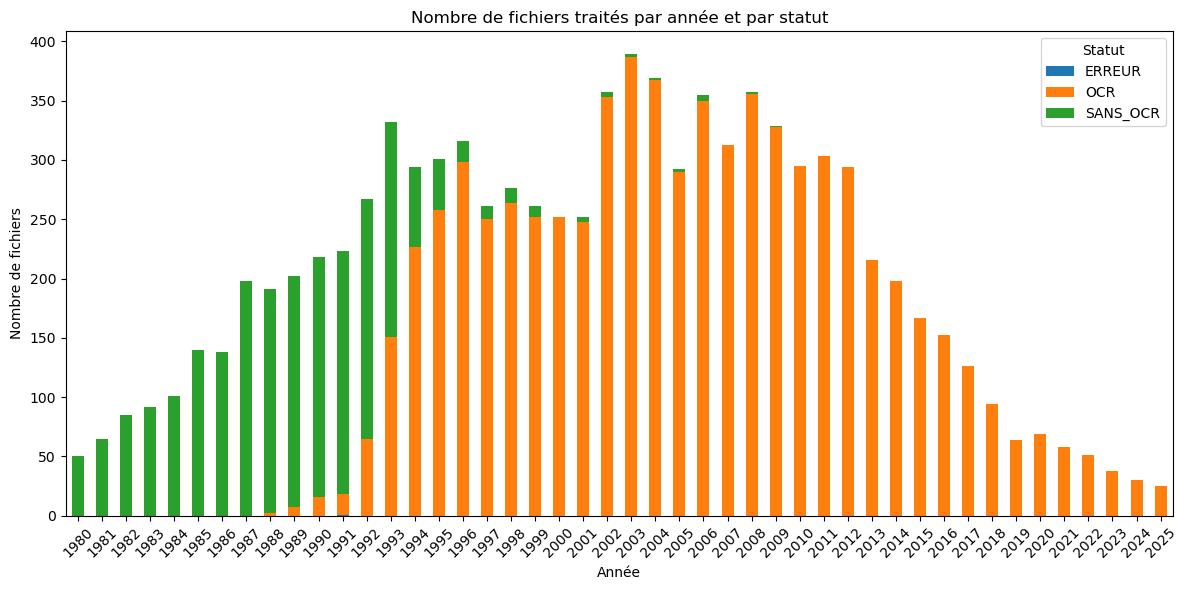


📊  Résumé global :
Statut Année  ERREUR  OCR  SANS_OCR
0       1980       0    0        50
1       1981       0    0        65
2       1982       0    0        85
3       1983       0    0        92
4       1984       0    0       101
5       1985       0    0       140
6       1986       0    0       138
7       1987       0    0       198
8       1988       0    2       189
9       1989       0    7       195
10      1990       0   16       202
11      1991       1   17       205
12      1992       0   65       202
13      1993       0  151       181
14      1994       0  227        67
15      1995       0  258        43
16      1996       0  298        18
17      1997       0  250        11
18      1998       0  264        12
19      1999       0  252         9
20      2000       0  252         0
21      2001       0  248         4
22      2002       0  353         4
23      2003       0  387         2
24      2004       0  367         2
25      2005       0  290         2
26      

In [37]:
#test 2 

"""
Tri des PDF RRT : OCR partiel vs. pages non‑OCR
------------------------------------------------
• Si au moins 5 pages sont océrisées         ➜  RRT_OCR
• Sinon (moins de 5 pages océrisées)         ➜  RRT_SANS_OCR
• Les pages blanches sont ignorées
"""

import os
import csv
import subprocess
from pathlib import Path
from shutil import copyfile

import fitz           # PyMuPDF
from PyPDF2 import PdfReader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Paramètres de répertoire
# ---------------------------------------------------------------------------
BASE_DIR           = Path("output")
DOSSIER_SOURCE     = BASE_DIR / "liste_pdf_rrt"
DOSSIER_OCR        = BASE_DIR / "RRT_OCR"
DOSSIER_SANS_OCR   = BASE_DIR / "RRT_SANS_OCR"
DOSSIER_RAPPORTS   = BASE_DIR / "rapports"
DOSSIER_TEMP       = BASE_DIR / "REPARATION_TEMP"

for d in (DOSSIER_OCR, DOSSIER_SANS_OCR, DOSSIER_RAPPORTS, DOSSIER_TEMP):
    d.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------------------
# Fonctions utilitaires
# ---------------------------------------------------------------------------
def est_pdf_valide(pdf_path: Path) -> bool:
    """Teste l’ouverture du PDF et l’accès à la première page."""
    try:
        PdfReader(pdf_path).pages[0]
        return True
    except Exception:
        return False

def reparer_pdf(src: Path, dst: Path) -> bool:
    """Tente une reconstruction Ghostscript ; renvoie True si dst valide."""
    try:
        subprocess.run(
            [
                "gs",
                "-sDEVICE=pdfwrite",
                "-dPDFSETTINGS=/prepress",
                "-dNOPAUSE", "-dBATCH", "-dSAFER",
                f"-sOutputFile={dst}",
                str(src)
            ],
            capture_output=True,
            text=True,
            check=False
        )
        return est_pdf_valide(dst)
    except Exception:
        return False

def est_page_blanche(page) -> bool:
    """Retourne True si la page est vide (ni texte ni image significative)."""
    texte = page.get_text().strip()
    images = page.get_images(full=True)
    return not texte and len(images) == 0

def pdf_ocerise_selon_regle(pdf_path: Path, seuil: int = 5) -> bool:
    """
    Renvoie True si AU MOINS `seuil` pages non blanches contiennent du texte.
    Les pages blanches sont ignorées dans le comptage.
    """
    ocr_pages = 0
    with fitz.open(pdf_path) as doc:
        for page in doc:
            if est_page_blanche(page):
                continue
            if page.get_text().strip():
                ocr_pages += 1
            if ocr_pages >= seuil:
                return True
    return False

# ---------------------------------------------------------------------------
# Parcours des années
# ---------------------------------------------------------------------------
annees    = sorted(p.name for p in DOSSIER_SOURCE.iterdir() if p.is_dir())
all_rows  = []

for annee in annees:
    src_dir          = DOSSIER_SOURCE / annee
    pdfs             = list(src_dir.glob("*.pdf"))
    ocr_dir          = DOSSIER_OCR / annee
    sans_ocr_dir     = DOSSIER_SANS_OCR / annee
    ocr_dir.mkdir(parents=True, exist_ok=True)
    sans_ocr_dir.mkdir(parents=True, exist_ok=True)

    for pdf in tqdm(pdfs, desc=f"Année {annee}", ncols=90, colour="cyan"):
        statut, erreur, repare = "", "", "Non"
        try:
            # ----------------------------------------------------------------
            # 1) Validation / réparation éventuelle
            # ----------------------------------------------------------------
            cible = pdf
            if not est_pdf_valide(pdf):
                tentative = DOSSIER_TEMP / pdf.name
                if reparer_pdf(pdf, tentative):
                    cible, repare = tentative, "Oui"
                else:
                    raise ValueError("PDF corrompu (réparation impossible)")

            # ----------------------------------------------------------------
            # 2) Vérification OCR selon la nouvelle règle
            # ----------------------------------------------------------------
            if pdf_ocerise_selon_regle(cible):
                copyfile(pdf, ocr_dir / pdf.name)
                statut = "OCR"
            else:
                copyfile(pdf, sans_ocr_dir / pdf.name)
                statut = "SANS_OCR"

        except Exception as e:
            statut, erreur = "ERREUR", str(e)

        # Trace pour le rapport
        all_rows.append([annee, pdf.name, pdf.suffix.lower(), statut, repare, erreur])

# ---------------------------------------------------------------------------
# Rapports CSV + graphique
# ---------------------------------------------------------------------------
rapport_csv = DOSSIER_RAPPORTS / "rapport.csv"
with rapport_csv.open("w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Année", "Fichier", "Extension", "Statut", "Réparé", "Erreur"])
    writer.writerows(all_rows)

df_global  = pd.DataFrame(all_rows, columns=["Année", "Fichier", "Extension", "Statut", "Réparé", "Erreur"])
df_resume  = df_global.groupby(["Année", "Statut"]).size().unstack(fill_value=0).reset_index()
df_resume.to_csv(DOSSIER_RAPPORTS / "resume_global.csv", index=False)

plt.figure(figsize=(12, 6))
df_resume.set_index("Année").plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Nombre de fichiers traités par année et par statut")
plt.xlabel("Année")
plt.ylabel("Nombre de fichiers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(DOSSIER_RAPPORTS / "resume_plot.png")
plt.show()

print("\n📊  Résumé global :")
print(df_resume)
print(f"\n📝  Rapports enregistrés dans : {DOSSIER_RAPPORTS}")

# ---------------------------------------------------------------------------
# Nettoyage du dossier temporaire
# ---------------------------------------------------------------------------
for f in DOSSIER_TEMP.glob("*"):
    f.unlink()
try:
    DOSSIER_TEMP.rmdir()
except OSError:
    pass



## Génération du rapport HTML et PDF avec plotly

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# --- Création des données ---
df_global  = pd.DataFrame(all_rows, columns=["Année", "Fichier", "Extension", "Statut", "Réparé", "Erreur"])
df_resume  = df_global.groupby(["Année", "Statut"]).size().unstack(fill_value=0).reset_index()

# --- Graphique interactif ---
fig = px.bar(
    df_resume,
    x="Année",
    y=df_resume.columns[1:],  # toutes les colonnes sauf "Année"
    title="Nombre de fichiers traités par année et par statut",
    labels={"value": "Nombre de fichiers", "variable": "Statut"},
    barmode="stack",
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_layout(
    xaxis_title="Année",
    yaxis_title="Nombre de fichiers",
    legend_title="Statut",
    xaxis_tickangle=-45,
    bargap=0.2,
)

# Sauvegarde en HTML interactif
fig.write_html(str(DOSSIER_RAPPORTS / "resume_plot.html"))

# --- Tableau interactif ---
table_fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(df_resume.columns),
        fill_color='paleturquoise',
        align='left'
    ),
    cells=dict(
        values=[df_resume[col] for col in df_resume.columns],
        fill_color='lavender',
        align='left'
    )
)])

# Sauvegarde en HTML
table_fig.write_html(str(DOSSIER_RAPPORTS / "resume_table.html"))

# --- Sauvegarde CSV classique ---
df_resume.to_csv(DOSSIER_RAPPORTS / "resume_global.csv", index=False)

# --- Console output ---
print("\n📊  Résumé global :")
print(df_resume)
print(f"\n📈  Graphique enregistré dans : {DOSSIER_RAPPORTS / 'resume_plot.html'}")
print(f"📋  Tableau enregistré dans : {DOSSIER_RAPPORTS / 'resume_table.html'}")


# Etape 3 : Conversion des fichiers non océrisés en fichiers océrisé

- Parcourt les fichiers PDF du dossier RRT_SANS_OCR (ceux sans texte).
- Convertit chaque page en image.
- Applique l'OCR avec Tesseract pour extraire le texte.
- Enregistre un fichier .txt contenant le texte OCRisé dans un nouveau dossier : RRT_OCR_FROM_IMG.

Installer: pip install ocrmypdf pytesseract pdf2image pillow

## 📘 Script : OCR sur les fichiers non-OCR (image → texte)

### Marche à suivre pour faire fonctionner le script OCR

#### 1. Installer les dépendances Python

Assurez-vous d’avoir installé les paquets nécessaires :

```bash
pip install pdf2image pytesseract openpyxl tqdm ipywidgets
```

#### 2. Installer Poppler

`pdf2image` utilise **Poppler** pour convertir les pages PDF en images.

- Téléchargez Poppler pour Windows ici :  
  [https://github.com/oschwartz10612/poppler-windows/releases/latest](https://github.com/oschwartz10612/poppler-windows/releases/latest)

- Choisissez l’archive ZIP la plus récente et décompressez-la (par exemple sur le Bureau)
- Le chemin du dossier `bin` à utiliser dans le script sera quelque chose comme :  
  `C:\Users\<votre_nom>\Desktop\poppler-xx.xx.x\Library\bin`

#### 3. Installer Tesseract OCR

- Téléchargez et installez **Tesseract OCR** pour Windows :  
  [https://github.com/tesseract-ocr/tesseract/releases/latest](https://github.com/tesseract-ocr/tesseract/releases/latest)

- Pendant l’installation, sélectionnez les langues dont vous avez besoin (ex : français)
- Ajoutez le chemin du dossier `Tesseract` à votre variable d’environnement **PATH**  
  ou utilisez le chemin complet dans votre script (ex :  
  `pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"`)


In [ ]:
import os
from pathlib import Path
from pdf2image import convert_from_path
import pytesseract
from PyPDF2 import PdfMerger
from io import BytesIO
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display

# ====================
# OCR D'UN PDF (streaming)
# ====================
def ocr_pdf_file_streaming(args):
    input_pdf, output_base_dir, poppler_path, lang = args
    try:
        file = os.path.basename(input_pdf)
        year = os.path.basename(os.path.dirname(input_pdf))
        year_dir = os.path.join(output_base_dir, year)
        os.makedirs(year_dir, exist_ok=True)
        output_pdf = os.path.join(year_dir, file)

        # OCR en streaming → ajout direct page par page
        merger = PdfMerger()
        pages = convert_from_path(input_pdf, dpi=300, poppler_path=poppler_path)

        for page in tqdm(pages, desc=f"OCR {file}", leave=False):
            pdf_bytes = pytesseract.image_to_pdf_or_hocr(page, extension='pdf', lang=lang)
            merger.append(BytesIO(pdf_bytes))

        with open(output_pdf, 'wb') as f_out:
            merger.write(f_out)

        return f"[OK] {file}"
    except Exception as e:
        return f"[ERREUR] {file} : {e}"

# ====================
# OCR POUR UN DOSSIER
# ====================
def ocr_pdf_folder_streaming(input_dir, output_dir, poppler_path, lang='fra'):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Récupérer tous les PDFs par année
    pdf_files = []
    for year in range(1980, 2026):
        year_dir = input_dir / str(year)
        if year_dir.exists():
            for file in os.listdir(year_dir):
                if file.lower().endswith('.pdf'):
                    pdf_files.append(str(year_dir / file))

    if not pdf_files:
        print("Aucun PDF trouvé dans le dossier source !")
        return

    print(f"Début OCR de {len(pdf_files)} fichiers...")

    results = []
    for pdf in tqdm(pdf_files, desc="PDFs"):
        res = ocr_pdf_file_streaming((pdf, str(output_dir), poppler_path, lang))
        results.append(res)

    for r in results:
        print(r)
    print("=== OCR terminé pour tous les PDFs ===")

# ====================
# WIDGETS JUPYTER
# ====================
src_w = widgets.Text(value=r'C:\xxxxxxxxxxxx\output\RRT_SANS_OCR',
                     description='Dossier source:')
dst_w = widgets.Text(value=r'C:\xxxxxxxxxxx\output\pdf_océrisés',
                     description='Dossier destination:')
poppler_w = widgets.Text(value=r'C:\xxxxxxxxxxx\poppler-25.07.0\Library\bin',
                         description='Chemin Poppler:')
lang_w = widgets.Dropdown(options=['fra', 'eng', 'deu'], value='fra', description='Langue OCR:')
btn_run = widgets.Button(description="Lancer OCR")
out = widgets.Output()

def on_btn_run_clicked(b):
    with out:
        out.clear_output()
        ocr_pdf_folder_streaming(
            input_dir=src_w.value,
            output_dir=dst_w.value,
            poppler_path=poppler_w.value,
            lang=lang_w.value
        )

btn_run.on_click(on_btn_run_clicked)
display(src_w, dst_w, poppler_w, lang_w, btn_run, out)